In [255]:
import MathOptInterface
using LinearAlgebra
const MOI = MathOptInterface
const GT = MOI.GreaterThan{Float64}
const LT = MOI.LessThan{Float64}

MathOptInterface.LessThan{Float64}

In [256]:
abstract type UnivariateFunction end
struct UnivariateAffineFunction <: UnivariateFunction
    a::Float64
    b::Float64
end

struct StaircaseFunction <: UnivariateFunction
    breakpoints::Vector{Float64}
    slopes::Vector{Float64}
    constant_terms::Vector{Float64}
    s::Float64
    function StaircaseFunction(bp::Vector{Float64}, slps::Vector{Float64}, cons::Vector{Float64})
        s = findmax(slps)[1]
        @assert length(Set(slps)) <= 2
        return new(bp, slps, cons, s)
    end
end

function eval(f::UnivariateFunction, x::Float64) end
function eval(f::UnivariateAffineFunction, x::Float64)
    return f.a*x + f.b
end

function eval(f::StaircaseFunction, x::Float64)
    bp = f.breakpoints
    n = length(bp)
    @assert x >= bp[1] && x <= bp[n]
    if x == bp[n]
        return f.slopes[n-1]*x + f.constant_terms[n-1]
    else
        i = searchsortedlast(bp, x)
        return f.slopes[i]*x + f.constant_terms[i]
    end
end

eval (generic function with 4 methods)

In [257]:
struct BoxDomain
    lowerbound::Vector{Float64}
    upperbound::Vector{Float64}
    function BoxDomain(L::Vector{Float64}, U::Vector{Float64})
        for (l, u) in zip(L, U)
            if l > u
                error("srsly dude ?!?")
            end
        end
        return new(L, U)
    end
end

In [258]:
struct Neuron{F<:Union{StaircaseFunction, UnivariateAffineFunction}}
    weight::Vector{Float64}
    bias::Float64
    activation::F
    input_domain::BoxDomain
    Δ::Vector{Float64}
    H₁::Vector{Vector{Float64}} # coefficients of ψ when θ² = 0 
    H₂::Vector{Vector{Float64}} # coefficients of ψ when θ¹ = 0
end

In [259]:
function Neuron(
    w::Vector{Float64},
    b::Float64,
    f::StaircaseFunction,
    D::BoxDomain,
    )
    U = D.upperbound
    L = D.lowerbound
    n = length(w)
    h = f.breakpoints
    k = length(h) - 1
    
    Δ = [(U[j] - L[j])*abs(w[j]) for j in 1:n]
    
    h₁ = h[2:k+1] .- b .- sum([w[i]*U[i] for i in 1:n if w[i] > 0]) .- 
                        sum([w[i]*L[i] for i in 1:n if w[i] < 0])
    H₁ = [h₁ .+ sum(Δ[i:n]) for i in 1:n+1]
    
    h₂ = -h[k:-1:1] .+ b .+ sum([w[i]*U[i] for i in 1:n if w[i] < 0]) .+ 
                        sum([w[i]*L[i] for i in 1:n if w[i] > 0])
    H₂ = [h₂ .+ sum(Δ[i:n]) for i in 1:n+1]
    return Neuron(w, b, f, D, Δ, H₁, H₂)
end

Neuron

In [260]:
function sanitycheck(
        neuron::Neuron,
        x::Vector{Float64}, 
        z::Vector{Float64},
    )
    if length(neuron.weight) != length(x)
        error("Unmatch weight and input length!")
    elseif length(neuron.activation.slopes) != length(z)
        error("Unmatch number of pieces in activation function and number of variables z!")
    elseif !isapprox(sum(z), 1) || any(z .< 0)
        error("Variables z are not in a simplex!")
    elseif any(x .< neuron.input_domain.lowerbound) || any(x .> neuron.input_domain.upperbound)
        error("Variables x are out of neuron input domain")
    end
    return nothing
end

sanitycheck (generic function with 1 method)

In [261]:
"""
Generate the coeficient for the z variables given an alpha
"""
function generate_zcoef_from_alpha(
        neuron::Neuron{StaircaseFunction},
        alpha::Vector{Float64},
        sign::Union{LT, GT},
    )
    w = neuron.weight
    @assert all(abs.(alpha) .<= abs.(w))
    bias = neuron.bias
    b = neuron.activation.constant_terms
    
    h = neuron.activation.breakpoints .- bias
    c₀ = -alpha
    c₁ = neuron.activation.s*w - alpha
    
    if sign isa GT
        z₀ = solve_knapsackseries(c₀, neuron.input_domain, w, h)
        z₁ = solve_knapsackseries(c₁, neuron.input_domain, w, h)
    elseif sign isa LT
        z₀ = -solve_knapsackseries(-c₀, neuron.input_domain, w, h)
        z₁ = -solve_knapsackseries(-c₁, neuron.input_domain, w, h)
    end
    a = neuron.activation.slopes
    return [a[i] > 0 ? z₁[i] + a[i]*bias + b[i] : z₀[i] + b[i] for i in 1:length(a)]
end

generate_zcoef_from_alpha

In [262]:
"""
Solve a series of knapsack-like problems of the form
       max c ⋅ x
subject to hᵢ ≤ w ⋅ x ≤ hᵢ₊₁
           L ≤ x ≤ U
for i ∈ {0, 1, 2, ..., k}. Here, we assume that when x is constrained in
the box domain [L, U], max w ⋅ x = hₖ₊₁ and min w ⋅ x = h₀.

The algorithm first solve max c ⋅ x with only one constraint that x lies
in the box domain [L, U] to obtain an original optimal solution x₀. Then
we find an index i₀ such that hᵢ₀ ≤ w ⋅ x₀ ≤ hᵢ₀₊₁. Next, we progress up
ward and downward from i₀ to solve the remaining problems.

The time complexity for this algorithm is O(max(k,n) + nlogn). However, 
in the context of network verification, the dimension of input to a neu-
ron n is usually larger than the number of pieces k in its activation 
function. Thus, the time complexity of this algorithm for this particular
application is O(nlogn).

"""
function solve_knapsackseries(
        c::Vector{Float64},
        box::BoxDomain,
        w::Vector{Float64},
        h::Vector{Float64},
    )
    U = box.upperbound
    L = box.lowerbound
    n = length(w)
    k = length(h) - 1
    z_coef = zeros(k)
    
    x₀ = [c[i] > 0 ? U[i] : L[i] for i in 1:n]
    i₀ = min(searchsortedlast(h, w ⋅ x₀), k)
    
    var_score = [(i, w[i] != 0 ? c[i]/w[i] : Inf) for i in 1:n]
    upperhalf_var_order = sort(filter(x -> x[2] <= 0, var_score), by = x -> abs(x[2]))
    lowerhalf_var_order = sort(filter(x -> x[2] >= 0, var_score), by = x -> abs(x[2]))
    
    z_coef[i₀] = c ⋅ x₀
    j = 1
    optsol = copy(x₀)
    count1 = 0
    for i in i₀+1:1:k
        while h[i] > w ⋅ optsol
            gap = h[i] - w ⋅ optsol
            var, value = upperhalf_var_order[j]
            update = optsol[var] + gap / w[var]
            if w[var] < 0
                if L[var] >= update
                    optsol[var] = L[var]
                    j += 1
                else
                    optsol[var] = update
                end
            else
                if U[var] <= update
                    optsol[var] = U[var]
                    j += 1
                else
                    optsol[var] = update
                end
            end
            count1 += 1
        end
        z_coef[i] = c ⋅ optsol
    end
    j = 1
    optsol = copy(x₀)
    count2 = 0
    for i in i₀-1:-1:1
        while h[i+1] < w ⋅ optsol
            gap = h[i+1] - w ⋅ optsol
            var, value = lowerhalf_var_order[j]
            update = optsol[var] + gap / w[var]
            if w[var] > 0
                if L[var] >= update
                    optsol[var] = L[var]
                    j += 1
                else
                    optsol[var] = update
                end
            else
                if U[var] <= update
                    optsol[var] = U[var]
                    j += 1
                else
                    optsol[var] = update
                end
            end
            count2 += 1
        end
        z_coef[i] = c ⋅ optsol
    end
    return z_coef
end

solve_knapsackseries

In [263]:
function optimal_ψ(
        x::Vector{Float64},
        z::Vector{Float64},
        Δ::Vector{Float64},
        H::Vector{Vector{Float64}},
    )
    n = length(x)
    k = length(z)
    breakpoints = [x[i]/Δ[i]  for i in 1:n]
    p = sortperm(breakpoints)
    sort!(breakpoints)
    pushfirst!(breakpoints, 0.0)
    push!(breakpoints, 1.0)
    x_bar = deepcopy(x)
    pushfirst!(x_bar, 0.0)
    Δ_bar = deepcopy(Δ)
    pushfirst!(Δ_bar, 0.0)

    optimal_value = 0.0
    optimal_solution = zeros(k)
    weighted_sum = 0.0 # sum of z_iq_i
    i = 2
    j = 1
    while optimal_value >= 0 && i <= n+2
        optimal_value = optimal_value - weighted_sum*Δ_bar[i-1] + x_bar[i-1]
        for var in j:k
            if z[var] == 0.0
                j += 1
                continue
            end
            if H[i-1][var] <= 0
                if z[var]*(1 - optimal_solution[var]) <= breakpoints[i] - weighted_sum
                    optimal_value += H[i-1][var]*(1 - optimal_solution[var])*z[var]
                    weighted_sum += z[var]*(1 - optimal_solution[var])
                    optimal_solution[var] = 1
                    j += 1
                else
                    optimal_solution[var] += (breakpoints[i] - weighted_sum) / z[var]
                    optimal_value += H[i-1][var]*(breakpoints[i] - weighted_sum)
                    weighted_sum = breakpoints[i]
                    break
                end
            else
                if weighted_sum >= breakpoints[i-1]
                    break
                end
                if z[var]*(1 - optimal_solution[var]) <= breakpoints[i-1] - weighted_sum
                    optimal_value += H[i-1][var]*(1 - optimal_solution[var])*z[var]
                    weighted_sum += z[var]*(1 - optimal_solution[var])
                    optimal_solution[var] = 1
                    j += 1
                else
                    optimal_solution[var] += (breakpoints[i-1] - weighted_sum) / z[var]
                    optimal_value += H[i-1][var]*(breakpoints[i-1] - weighted_sum)
                    weighted_sum = breakpoints[i-1]
                    break
                end
            end
        end
        i = i + 1
    end
    return optimal_value, i-3, p
end

optimal_ψ (generic function with 1 method)

In [264]:
function generate_alpha(
        neuron::Neuron{StaircaseFunction},
        x::Vector{Float64},
        y::Float64,
        z::Vector{Float64},
    )
    w = neuron.weight
    s = neuron.activation.s
    b = neuron.bias
    h = neuron.activation.breakpoints
    L = neuron.input_domain.lowerbound
    U = neuron.input_domain.upperbound
    n = length(w)
    k = length(h) - 1
    
    Δ = neuron.Δ
    H = neuron.H₁
    x_bar = [w[j] > 0 ? (U[j]-x[j])*w[j] : (L[j] - x[j])*w[j] for j in 1:n]
    opt_value1, k₁, p1 = optimal_ψ(x_bar, z, Δ, H)
    
    H = neuron.H₂ #increasing order
    x_bar = [w[j] < 0 ? (x[j]-U[j])*w[j] : (x[j] - L[j])*w[j] for j in 1:n]
    opt_value2, k₂, p2 = optimal_ψ(x_bar, z[k:-1:1], Δ, H) #reordering H also requires reordering z
    
    alpha = zeros(n)
    if opt_value1 >= -eps() && opt_value2 >= -eps()
        return nothing
    elseif opt_value1 < 0
        for i in 1:k₁
            alpha[p1[i]] = w[p1[i]] > 0 ? -w[p1[i]] : (w[p1[i]] < 0 ? -w[p1[i]] : 0)
        end
        return alpha
    elseif opt_value2 < 0
        for i in 1:k₂
            alpha[p2[i]] = w[p2[i]] < 0 ? w[p2[i]] : (w[p2[i]] > 0 ? w[p2[i]] : 0)
        end
        return alpha
    end
end

generate_alpha (generic function with 1 method)

In [265]:
function separate(
        neuron::Neuron{StaircaseFunction},
        x::Vector{Float64},
        y::Float64,
        z::Vector{Float64},
    )
    alpha = generate_alpha(neuron, x, y, z)
    if alpha == nothing
        #print("\nfeasible point!\n")
        return nothing
    else
        upper_z_coef = generate_zcoef_from_alpha(neuron, alpha, GT(y))
        lower_z_coef = generate_zcoef_from_alpha(neuron, alpha, LT(y))
        return alpha, upper_z_coef, lower_z_coef
    end
end

separate (generic function with 1 method)

In [266]:
import Pickle
using JuMP, Gurobi
using Plots
#neural_net = Pickle.load(open("models/MNIST-BAN_Dense100-Dense100.pkl"))
img = Pickle.load(open("imgs/MNIST_images-for-verification"))
#img = vcat([w' for w in img]...)
#img = rotl90(img, 1)
#img = rot180(img, 1)

150-element Vector{Any}:
 Any[Any[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0  …  -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], Any[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0  …  -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], Any[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0  …  -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], Any[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0  …  -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], Any[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0  …  -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], Any[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0  …  -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], Any[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0  …  -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], Any[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.3411764705882353, 0.45098039215

In [267]:
im3 = vcat([w' for w in img[3]]...)
#im3 = rotr90(im3, 1)
#im3 = rot180(im3, 1)
im3 = im3'
im3 = rotr90(im3, 1)

28×28 Matrix{Any}:
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
  ⋮                             ⋮    ⋱                     ⋮          
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.

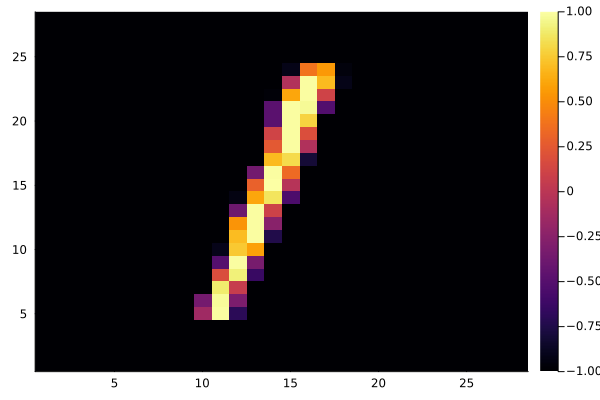

In [268]:
heatmap(im3)

In [269]:
function preprocess(neural_net)
    n = length(neural_net)
    nn = []
    for i in 1:n ÷ 2
        weight = vcat([w' for w in neural_net[2*i-1]]...) #convert to matrix
        bias = neural_net[2*i]
        push!(nn, (weight, bias))
    end
    return nn
end

neural_net = preprocess(neural_net)

3-element Vector{Any}:
 (Any[0.0637546256184578 0.030542615801095963 … -0.01704624481499195 -0.045919422060251236; -0.07338358461856842 0.03578795865178108 … -0.0669010654091835 0.04828004911541939; … ; 0.08795399218797684 -0.048103366047143936 … -0.0034914123825728893 0.012065937742590904; -0.03691847249865532 -0.06861673295497894 … 0.0784282311797142 -0.009276054799556732], Any[-0.008920266292989254, -0.005168737843632698, -0.0033934179227799177, -0.03224657103419304, 0.013476555235683918, -0.012305094860494137, -0.01248625386506319, -0.0074222818948328495, 0.0075399004854261875, -0.010488776490092278  …  0.007036473136395216, 0.002399336313828826, -0.0032835742458701134, -0.00949111394584179, -0.004926173482090235, -0.010798041708767414, -0.00943837407976389, -0.007351759821176529, -0.007448825053870678, 0.01987157016992569])
 (Any[0.10263989865779877 0.10074391216039658 … -0.04494774714112282 -0.03259526938199997; -0.0866151750087738 0.16398434340953827 … -0.005003910977393389 -0.0

In [270]:
function init_mip_model(neural_net, image, true_label, eps = 0.01) #binary activation
    neurons_by_layer = [length(bias) for (weight, bias) in neural_net] #including input & output layer
    pushfirst!(neurons_by_layer, size(neural_net[1][1])[1])
    nums_layer = length(neurons_by_layer)
    mip = Model(Gurobi.Optimizer)
    set_silent(mip)
    @variable(mip, -1 <= x[i = 1:nums_layer-1, j = 1:neurons_by_layer[i]] <= 1)
    for (i, val) in enumerate(image)
        @constraint(mip, max(val-eps, -1.0) <= mip[:x][1, i] <= min(val+eps, 1.0))
    end
    @variable(mip, 0 <= z[i = 2:nums_layer-1, j = 1:neurons_by_layer[i], k = 1:2] <= 1, Bin)
    variable_neuron_dict = Dict()
    
    for (i , (weights, bias)) in enumerate(neural_net[1:nums_layer-2])
        n, m = size(weights)
        for j in 1:m
            w = Array{Float64}(weights[1:n, j])
            b = bias[j]
            l = sum([w[k] > 0 ? -w[k] : w[k] for k in 1:n])
            f = StaircaseFunction([l + b, 0.0, -l + b], [0.0, 0.0], [-1.0, 1.0])
            D = BoxDomain(-ones(n), ones(n))
            neuron = Neuron(w, b, f, D)
            variable_neuron_dict[mip[:x][i+1, j]] = neuron
            
            @constraint(mip, mip[:z][i+1,j,1] + mip[:z][i+1,j,2] == 1)
            @constraint(mip, mip[:x][i+1,j] + mip[:z][i+1,j,1] - mip[:z][i+1,j,2] == 0)
        end
    end
    return mip, variable_neuron_dict        
end

init_mip_model (generic function with 2 methods)

In [271]:
using Printf
function verify(neural_net, image, true_label, objective, eps = 0.01, max_iter = 1000)
    # set objective for mip model
    mip, variable_neuron_dict = init_mip_model(neural_net, image, true_label, eps)
    last_layer = last(neural_net)[1]
    c = last_layer * objective
    #=for i in 2:10
        @constraint(mip, sum(last_layer[1:100, i][j]*mip[:x][3, j] for j in 1:100) <=
                         sum(last_layer[1:100, i][1]*mip[:x][3, j] for j in 1:100))
    end=#
    num_layers = length(neural_net)
    final_dim, output_dim = size(last(neural_net)[1])
    @objective(mip, Max, sum(c[i]*mip[:x][num_layers, i] for i in 1:final_dim))
    
    # separation procedure
    feasible = false
    count = 0
    generated_alpha = Dict()
    for (key, value) in variable_neuron_dict
        generated_alpha[key] = Set()
    end
    while !feasible && count < max_iter
        @printf("solving %d-th problem: \n", count+1)
        @time optimize!(mip)
        #TODO: parallel this part?
        feasible = true
        for (i, (weights, bias)) in enumerate(neural_net[1:num_layers-1])
            n, m = size(weights)
            @printf("   generate violating inequalities of layer %d: \n   ", i+1)
            @time for j in 1:m
                y = value(mip[:x][i+1, j])
                x = value.([mip[:x][i, k] for k in 1:n])
                z = value.([mip[:z][i+1,j,1], mip[:z][i+1,j,2]])
                neuron = variable_neuron_dict[mip[:x][i+1, j]]
                alpha = generate_alpha(neuron, x, y, z)
                if alpha != nothing && !(alpha in generated_alpha[mip[:x][i+1, j]])
                    push!(generated_alpha[mip[:x][i+1, j]], alpha)
                    upper_z = generate_zcoef_from_alpha(neuron, alpha, GT(y))
                    lower_z = generate_zcoef_from_alpha(neuron, alpha, LT(y))
                    @constraint(mip, mip[:x][i+1, j] <= sum(mip[:x][i, k]*alpha[k] for k in 1:n) +
                                     sum(mip[:z][i+1, j, k]*upper_z[k] for k in 1:2)) 
                    @constraint(mip, mip[:x][i+1, j] >= sum(mip[:x][i, k]*alpha[k] for k in 1:n) +
                                     sum(mip[:z][i+1, j, k]*lower_z[k] for k in 1:2))
                    feasible = false
                end
            end
        end
        count += 1
    end
    return objective_value(mip), value.(mip[:x]), value.(mip[:z])
end

verify (generic function with 3 methods)

In [272]:
@time opt_val, opt_sol_x, opt_sol_z = verify(neural_net, img, 2, [0.0, 0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1/8)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-15


ErrorException: Operation `sub_mul` between `Vector{Vector{Float64}}` and `Float64` is not allowed. You should use broadcast.

In [273]:
@time opt_val, opt_sol_x, opt_sol_z = verify(neural_net, img, 2, [-1.0, -1.0, -1.0, 10.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], 0.15)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-15


ErrorException: Operation `sub_mul` between `Vector{Vector{Float64}}` and `Float64` is not allowed. You should use broadcast.

In [274]:
w1, b1 = neural_net[1]
w2, b2 = neural_net[2]
w3, b3 = neural_net[3]

(Any[-0.16810764372348785 0.0908636599779129 … 0.29462355375289917 0.12655341625213623; 0.10643213987350464 -0.02404194325208664 … 0.14130260050296783 0.011345014907419682; … ; 0.10184700042009354 -0.17890161275863647 … -0.08974038064479828 -0.16659808158874512; -0.19930283725261688 0.09014824777841568 … 0.05094803124666214 -0.11923925578594208], Any[-0.0799298956990242, -0.015273730270564556, 0.05843355506658554, 0.029641706496477127, -0.023213569074869156, 0.03812182694673538, -0.10885021090507507, 0.02888825163245201, 0.006291170138865709, 0.02623017691075802])

In [275]:
for j in 1:100
    a = w2[1:100, j] ⋅ [opt_sol_x[2, i] for i in 1:100] + b2[j]
    if a > 0
        if opt_sol_x[3, j] != 1.0
            print(a)
            print("\n")
        end
    elseif a < 0
        if opt_sol_x[3, j] != -1.0
            print(a)
            print("\n")
        end
    end
end

UndefVarError: UndefVarError: `opt_sol_x` not defined

In [276]:
for j in 1:100
    a = w1[1:784, j] ⋅ [opt_sol_x[1, i] for i in 1:784] + b1[j]
    if a > 0
        if opt_sol_x[2, j] != 1.0
            print(a)
            print("\n")
        end
    elseif a < 0
        if opt_sol_x[2, j] != -1.0
            print(a)
            print("\n")
        end
    end
end

UndefVarError: UndefVarError: `opt_sol_x` not defined

In [277]:
ret_img = [opt_sol_x[1, i] for i in 1:784]
ret_img = reshape(ret_img, (28, 28))

UndefVarError: UndefVarError: `opt_sol_x` not defined

In [278]:
heatmap(-ret_img', color = :greys)

UndefVarError: UndefVarError: `ret_img` not defined

In [279]:
heatmap(reshape(-img, 28, 28)', color = :grays)

DimensionMismatch: DimensionMismatch: new dimensions (28, 28) must be consistent with array size 150

In [280]:
diff = ret_img - reshape(img, 28, 28)

UndefVarError: UndefVarError: `ret_img` not defined

In [281]:
heatmap(-diff', color = :greys)

MethodError: MethodError: no method matching adjoint(::typeof(diff))

Closest candidates are:
  adjoint(!Matched::Union{QR, LinearAlgebra.QRCompactWY, QRPivoted})
   @ LinearAlgebra /opt/homebrew/Cellar/julia/1.9.4/share/julia/stdlib/v1.9/LinearAlgebra/src/qr.jl:517
  adjoint(!Matched::Union{Cholesky, CholeskyPivoted})
   @ LinearAlgebra /opt/homebrew/Cellar/julia/1.9.4/share/julia/stdlib/v1.9/LinearAlgebra/src/cholesky.jl:556
  adjoint(!Matched::Union{MathOptInterface.VariableIndex, MathOptInterface.ScalarAffineFunction{T}, MathOptInterface.ScalarQuadraticFunction{T}} where T)
   @ MathOptInterface ~/.julia/packages/MathOptInterface/nEHaN/src/Utilities/functions.jl:1836
  ...


In [282]:
count = 0
for val in opt_sol_z
    if val > eps() && val < 1.0 - eps()
        count += 1
    end
end
print(count)

UndefVarError: UndefVarError: `opt_sol_z` not defined

In [284]:
opt_val

UndefVarError: UndefVarError: `opt_val` not defined

In [285]:
w1 = [0.25 -0.75; 0.5 0.5]
b1 = [-0.3; 0.6]
w2 = [1 1]'
b2 = [0 0]'
test_nn = [(w1, b1), (w2, b2)]
verify(test_nn, [1], 6)

MethodError: MethodError: no method matching verify(::Vector{Tuple{AbstractMatrix, AbstractArray}}, ::Vector{Int64}, ::Int64)

Closest candidates are:
  verify(::Any, ::Any, ::Any, !Matched::Any)
   @ Main ~/OR-Research/LinSepVerify/Verification Demo.ipynb:2
  verify(::Any, ::Any, ::Any, !Matched::Any, !Matched::Any)
   @ Main ~/OR-Research/LinSepVerify/Verification Demo.ipynb:2
  verify(::Any, ::Any, ::Any, !Matched::Any, !Matched::Any, !Matched::Any)
   @ Main ~/OR-Research/LinSepVerify/Verification Demo.ipynb:2


In [286]:
model, dict = init_mip_model(test_nn)

MethodError: MethodError: no method matching init_mip_model(::Vector{Tuple{AbstractMatrix, AbstractArray}})

Closest candidates are:
  init_mip_model(::Any, !Matched::Any, !Matched::Any)
   @ Main ~/OR-Research/LinSepVerify/Verification Demo.ipynb:1
  init_mip_model(::Any, !Matched::Any, !Matched::Any, !Matched::Any)
   @ Main ~/OR-Research/LinSepVerify/Verification Demo.ipynb:1


In [287]:
w1 = [0.25 -0.75]'
b1 = [0.5]
w2 = [1]'
b2 = [0]
test_nn = [(w1, b1), (w2, b2)]
verify(test_nn, [1], 3)

MethodError: MethodError: no method matching verify(::Vector{Tuple{Adjoint, Vector}}, ::Vector{Int64}, ::Int64)

Closest candidates are:
  verify(::Any, ::Any, ::Any, !Matched::Any)
   @ Main ~/OR-Research/LinSepVerify/Verification Demo.ipynb:2
  verify(::Any, ::Any, ::Any, !Matched::Any, !Matched::Any)
   @ Main ~/OR-Research/LinSepVerify/Verification Demo.ipynb:2
  verify(::Any, ::Any, ::Any, !Matched::Any, !Matched::Any, !Matched::Any)
   @ Main ~/OR-Research/LinSepVerify/Verification Demo.ipynb:2


In [288]:
model = Model(Gurobi.Optimizer)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-15


A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi

In [289]:
@variable(model, x)
@variable(model, y)
@constraint(model, x + y <= 1)

x + y ≤ 1

In [290]:
model

A JuMP Model
Feasibility problem with:
Variables: 2
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 1 constraint
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi
Names registered in the model: x, y

In [291]:
@constraint(model, x + y <= 1)

x + y ≤ 1

In [292]:
model

A JuMP Model
Feasibility problem with:
Variables: 2
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 2 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi
Names registered in the model: x, y

# Tests

In [294]:
f = StaircaseFunction([-1.0, 0.0, 1.0], [0.0, 0.0], [-1.0, 1.0])

StaircaseFunction([-1.0, 0.0, 1.0], [0.0, 0.0], [-1.0, 1.0], 0.0)

In [295]:
nr = Neuron([1.0, 1.0], 0.0, f, BoxDomain([-0.5, -0.5], [0.5, 0.5]))

Neuron{StaircaseFunction}([1.0, 1.0], 0.0, StaircaseFunction([-1.0, 0.0, 1.0], [0.0, 0.0], [-1.0, 1.0], 0.0), BoxDomain([-0.5, -0.5], [0.5, 0.5]), [1.0, 1.0], [[1.0, 2.0], [0.0, 1.0], [-1.0, 0.0]], [[1.0, 2.0], [0.0, 1.0], [-1.0, 0.0]])

In [296]:
x = [-0.25, -0.35]
y = 1.0
z = [0.0, 1.0]
#alpha = generate_alpha(nr, x, y, z) # 1 1
z_coef = separate(nr, x, y, z)

([1.0, 1.0], [0.0, 1.0], [-1.0, 0.0])

In [297]:
x = [-0.25, -0.35]
y = 1.0
z = [0.6, 0.4]
alpha = generate_alpha(nr, x, y, z) #feasible

In [298]:
nr = Neuron([1.0, -1.0], 0.0, f, BoxDomain([-0.5, -0.5], [0.5, 0.5]))

Neuron{StaircaseFunction}([1.0, -1.0], 0.0, StaircaseFunction([-1.0, 0.0, 1.0], [0.0, 0.0], [-1.0, 1.0], 0.0), BoxDomain([-0.5, -0.5], [0.5, 0.5]), [1.0, 1.0], [[1.0, 2.0], [0.0, 1.0], [-1.0, 0.0]], [[1.0, 2.0], [0.0, 1.0], [-1.0, 0.0]])

In [299]:
x = [0.25, 0.35]
y = 1.0
z = [0.0, 1.0]
alpha = generate_alpha(nr, x, y, z) # 1 1

2-element Vector{Float64}:
  1.0
 -1.0

In [300]:
x = [0.35, -0.35]
y = 1.0
z = [0.0, 1.0]
alpha = generate_alpha(nr, x, y, z) # 1 1

In [301]:
c = [2.0]
box = BoxDomain([-1.0], [1.0])
w = [1.0]
h = [-1.0, -0.5, 0.5, 1.0]
solve_knapsackseries(c, box, w, h)

3-element Vector{Float64}:
 -1.0
  1.0
  2.0

In [302]:
c = [-1.0]
box = BoxDomain([-1.0], [1.0])
w = [1.0]
h = [-1.0, -0.5, 0.5, 1.0]
solve_knapsackseries(c, box, w, h)

3-element Vector{Float64}:
  1.0
  0.5
 -0.5

In [303]:
c = [-1.0, 2.5]
box = BoxDomain([-2.0, -2.0], [1.0, 1.0])
w = [0.5, -1.0]
h = [-2.0, -1.0, 0.0, 2.5]
solve_knapsackseries(c, box, w, h)

3-element Vector{Float64}:
 4.5
 2.5
 0.25

In [304]:
c = [1.5, 2.5]
box = BoxDomain([-2.0, -2.0], [1.0, 1.0])
w = [0.5, -1.5]
h = [-2.5, -1.0, 0.0, 3.5]
solve_knapsackseries(c, box, w, h)

3-element Vector{Float64}:
 4.0
 4.0
 2.3333333333333335

In [305]:
c = [1.5, 0.0]
box = BoxDomain([-2.0, -2.0], [1.0, 1.0])
w = [0.5, -1.5]
h = [-2.5, -2.0, -1.0, 0.0, 3.5]
solve_knapsackseries(c, box, w, h)

4-element Vector{Float64}:
 -1.5
  1.5
  1.5
  1.5

In [306]:
c = [1.5, 0.0]
box = BoxDomain([-2.0, -2.0], [1.0, 1.0])
w = [0.5, 0.0]
h = [-1.0, -0.5, -0.25, 0.0, 1.0]
solve_knapsackseries(c, box, w, h)

4-element Vector{Float64}:
 -1.5
 -0.75
  0.0
  1.5

In [307]:
c = [1.5, 0.0]
box = BoxDomain([-2.0, -2.0], [1.0, 1.0])
w = [0.0, 0.5]
h = [-1.0, -0.5, -0.25, 0.0, 1.0]
solve_knapsackseries(c, box, w, h)

4-element Vector{Float64}:
 1.5
 1.5
 1.5
 1.5

In [308]:
f = StaircaseFunction([-1.0, 0.0, 1.0], [0.0, 1.0], [0.0, 0.0])
nr = Neuron([1.0, 1.0], 0.0, f, BoxDomain([-0.5, -0.5], [0.5, 0.5]))
generate_zcoef_from_alpha(nr, [0.0, 0.0], LT(0))

2-element Vector{Float64}:
 0.0
 0.0

In [309]:
generate_zcoef_from_alpha(nr, [0.0, 0.0], GT(1))

2-element Vector{Float64}:
 0.0
 1.0

In [310]:
generate_zcoef_from_alpha(nr, [1.0, 0.0], GT(1))

2-element Vector{Float64}:
 0.5
 0.5

In [311]:
generate_zcoef_from_alpha(nr, [1.0, 0.0], LT(1))

2-element Vector{Float64}:
 -0.5
 -0.5

In [312]:
generate_zcoef_from_alpha(nr, [0.5, 0.5], GT(1))

2-element Vector{Float64}:
 0.5
 0.5

In [313]:
generate_zcoef_from_alpha(nr, [0.0, 0.5], GT(1))

2-element Vector{Float64}:
 0.25
 0.75

In [314]:
n = 800
k = 10
w = 2*(rand(Float64, n).-0.5)
u = ones(n)/n
l = -ones(n)/n
U = sum([w[i]*u[i] for i in 1:n if w[i] > 0]) + sum([w[i]*l[i] for i in 1:n if w[i] < 0])
L = sum([w[i]*u[i] for i in 1:n if w[i] < 0]) + sum([w[i]*l[i] for i in 1:n if w[i] > 0])
h = [L + (U-L)/k*(i-1) for i in 1:n+1]
h = h .- sum([w[i]*u[i] for i in 1:n if w[i] > 0]) .+ sum([w[i]*l[i] for i in 1:n if w[i] < 0])
Δ = [(u[i]-l[i])*abs(w[i]) for i in 1:n]
H = [h .+ sum(Δ[i:n]) for i in 1:n+1]

#x = (rand(Float64, n) .- 0.5)*2/n
#x = [w[j] > 0 ? u[j]*w[j] - x[j]*w[j] : l[j]*w[j] - x[j]*w[j] for j in 1:n]
x = [w[i] > 0 ? u[i] : l[i] for  i in 1:n]
x = [w[j] > 0 ? (u[j]-x[j])*w[j] : (l[j]-x[j])*w[j] for j in 1:n]
#z = rand(Float64, k)
#z = z/sum(z)
z = zeros(k)
z[1] = 0.5
z[2] = 0.5

@time sol, val = optimal_ψ(x, z, Δ, H)

  0.000111 seconds (15 allocations: 74.953 KiB)


(-0.44572934032072675, 800, [1, 5, 8, 14, 15, 16, 23, 25, 27, 29  …  777, 779, 782, 783, 784, 785, 794, 795, 798, 799])

In [315]:
x = [0.3, 0.6]
z = [0.5, 0.5]
Δ = [1.0, 1.0]
h = [-3.0, -2.0]
H = [h .+ sum(Δ[i:2]) for i in 1:3]

@time sol= optimal_ψ(x, z, Δ, H)

  0.000009 seconds (13 allocations: 1.312 KiB)


(-0.3, 0, [1, 2])

In [316]:
x = [0.3, 0.6]
z = [0.5, 0.5]
Δ = [1.0, 1.0]
h = [-2.0, -1.0]
H = [h .+ sum(Δ[i:2]) for i in 1:3]

@time sol = optimal_ψ(x, z, Δ, H)

  0.000007 seconds (13 allocations: 1.312 KiB)


(-0.2, 1, [1, 2])

In [317]:
x = [0.3, 0.6]
z = [0.1, 0.9]
Δ = [2.0, 2.0]
h = [-3.0, -2.0]
H = [h .+ sum(Δ[i:2]) for i in 1:3]

@time sol = optimal_ψ(x, z, Δ, H)

  0.000007 seconds (13 allocations: 1.312 KiB)


(-1.2, 2, [1, 2])

In [318]:
x = [0.25, 0.5, 0.75]
z = [1/3, 1/3, 1/3]
Δ = [1.0, 1.0, 1.0]
h = [-0.5, 0.0, 0.5]
H = [h .+ sum(Δ[i:3]) for i in 1:4]

@time sol = optimal_ψ(x, z, Δ, H)

  0.000007 seconds (13 allocations: 1.312 KiB)


(1.375, 3, [1, 2, 3])

In [319]:
sol

(1.375, 3, [1, 2, 3])

In [320]:
a = [1, 2, 3, 4, 5, 6]

6-element Vector{Int64}:
 1
 2
 3
 4
 5
 6

In [321]:
searchsortedlast(a, 1)

1

In [322]:
a

6-element Vector{Int64}:
 1
 2
 3
 4
 5
 6